In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud # pip install wordcloud

%matplotlib inline  

%run 'DataSet.py'
%run 'Processing.py'

Play  ['Hamlet' 'Othello' 'Henry V' 'Timon of Athens' 'Measure for Measure'
 'Antony and Cleopatra' 'King Lear' 'King Edward III' 'Julius Caesar'
 'Macbeth' 'Titus Andronicus' "The Winter's Tale" 'Richard III'
 'As You Like It' 'Coriolanus' 'The Tempest' 'Henry IV Part 2'
 'Romeo and Juliet' 'Pericles' 'Henry IV Part 1' 'Cymbeline'
 'The Two Noble Kinsmen' "Love's Labour's Lost" 'The Taming of the Shrew'
 'The Merchant of Venice' 'Troilus and Cressida' 'King John'
 "All's Well That Ends Well" 'Richard II' 'Henry VIII'
 'The Two Gentlemen of Verona' 'The Merry Wives of Windsor'
 'Henry VI Part 3' 'Much Ado About Nothing' 'Henry VI Part 1'
 'Henry VI Part 2' 'Twelfth Night' 'The Comedy of Errors'
 "A Midsummer Night's Dream"]
[('thou', 5333), ('thy', 3795), ('shall', 3572), ('thee', 3090), ('good', 2825), ('lord', 2679), ('come', 2531), ('sir', 2520), ('well', 2488), ('would', 2294)]


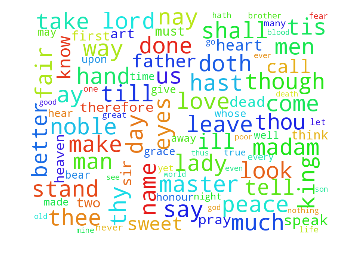

In [2]:
ds = DataSet()
ds.load()

tokens = Processing.get_tokens(ds.df['Utterance'], [Processing.remove_punctuation], [Processing.remove_stopwords])

allWordDist = nltk.FreqDist(tokens)

common_words = allWordDist.most_common(100)

# Print the top 10 words - shows some 'olde english' stop words
print(allWordDist.most_common(10))

words = ' '.join(entry[0] for entry in common_words)


# lower max_font_size
wordcloud = WordCloud(background_color='white', max_font_size=60,height=600, width=800).generate(words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


def run_tfidf(words):
    all_stopwords = stopwords.words('english') 

    #adding Shakespeare-ean stop-words
    shaksp_stopwords = ('thee', 'thou', 'thy', 'thine')
    all_stopwords += shaksp_stopwords

    tfidf_vectorizer = TfidfVectorizer(#max_features=200000,
                                        max_features=1000,
                                       # min_df=0.2, 
                                       #max_df=0.8, 
                                       stop_words=all_stopwords,
                                        use_idf=True, 
                                        tokenizer=tokenize_only, 
                                        ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(words)

    print('TFIDF: ', tfidf_matrix.shape)

    terms = tfidf_vectorizer.get_feature_names()
    print('Terms: ', terms)

    params = tfidf_vectorizer.get_params()
    #dist = 1 - cosine_similarity(tfidf_matrix)
    #print('Dist: ', dist)
    
    return tfidf_matrix, params
    
    
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems



def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens    
    


In [49]:
plays_utterances = ds.get_by_play()

tfidf_matrix, params = run_tfidf(plays_utterances.values())

TFIDF:  (37, 1000)
Terms:  ["'d", "'em", "'gainst", "'ll", "'ll make", "'ll tell", "'re", "'s", "'s death", "'s matter", "'s name", "'s son", "'t", "'t true", "'twere", "'twixt", 'achilles', 'act', 'action', 'adieu', 'advantage', 'affection', 'age', 'ah', 'air', 'alack', 'alas', 'alive', 'almost', 'alone', 'along', 'already', 'although', 'amen', 'among', 'ancient', 'angelo', 'angry', 'anne', 'anon', 'another', 'answer', 'antonio', 'antony', 'appear', 'approach', 'arm', 'arms', 'army', 'art', 'ask', 'ass', 'attend', 'aught', 'awake', 'away', 'awhile', 'ay', 'back', 'bad', 'banish', "banish 'd", 'base', 'battle', 'bear', 'beard', 'bears', 'beast', 'beat', 'beauty', 'become', 'bed', 'beg', 'beggar', 'begin', 'behind', 'behold', 'believe', 'beseech', 'besides', 'best', 'better', 'bid', 'birth', 'bitter', 'black', 'blame', 'bless', 'blessed', 'blind', 'blood', 'bloody', 'blow', 'blows', 'body', 'bold', 'bond', 'bones', 'book', 'born', 'bosom', 'bound', 'boy', 'boys', 'brain', 'brave', 'brea

In [50]:
from sklearn.cluster import KMeans
from collections import Counter
    
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()



In [51]:

plays_dict = { 'title': list(plays_utterances.keys()),'cluster': clusters}

frame = pd.DataFrame(plays_dict, index = [clusters] , columns = [
        'title', 'cluster'])


In [52]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]


print(order_centroids)
dense = tfidf_matrix.todense()

print(tfidf_matrix)

Top terms per cluster:

[[  7   0 755 ..., 581 380  42]
 [  7   0 755 ..., 135 195 840]
 [134   7 581 ..., 345 548 872]
 [  7 924 412 ..., 717  33  34]
 [122  43 117 ..., 446 453 118]]
  (0, 755)	0.17341399045
  (0, 865)	0.0181178795993
  (0, 562)	0.0207061481135
  (0, 7)	0.48918274918
  (0, 218)	0.0931776665106
  (0, 63)	0.008005740762
  (0, 525)	0.0155296110851
  (0, 254)	0.0310592221702
  (0, 751)	0.0181178795993
  (0, 830)	0.0103530740567
  (0, 653)	0.0232944166276
  (0, 905)	0.152707842337
  (0, 157)	0.134589962737
  (0, 126)	0.00909918937002
  (0, 39)	0.01819837874
  (0, 263)	0.0155296110851
  (0, 320)	0.0140056139726
  (0, 24)	0.0372021033781
  (0, 91)	0.0413478493132
  (0, 541)	0.085412860968
  (0, 707)	0.0239156378859
  (0, 811)	0.0181178795993
  (0, 508)	0.100942472053
  (0, 355)	0.132001694223
  (0, 787)	0.0177205068485
  :	:
  (36, 679)	0.00570622057159
  (36, 448)	0.00277641286514
  (36, 340)	0.00997600383524
  (36, 757)	0.0124700047941
  (36, 593)	0.0204900568204
  (36, 7

In [56]:
print(params)

{'binary': False, 'input': 'content', 'decode_error': 'strict', 'token_pattern': '(?u)\\b\\w\\w+\\b', 'sublinear_tf': False, 'stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 's